# CNN Baseline

## Imports and Helper Functions

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
# import tensorflow.contrib.keras as keras


from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
# import tensorflow_datasets as tfds
import tensorflow_text as tf_text

import sklearn as sk
import os
import nltk
from nltk.corpus import reuters
from nltk.data import find

import matplotlib as mpl
import matplotlib.pyplot as plt

import re

#This continues to work with gensim 3.8.3.  It doesn't yet work with 4.x.  
#Make sure your pip install command specifies gensim==3.8.3
import gensim

Below is a helper function to plot histories.

In [2]:
# 4-window plot of loss and accuracy for two models, for comparison

def make_plot(axs,
              model_history1, 
              model_history2, 
              model_1_name='model 1',
              model_2_name='model 2',
              ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy']):
        y_lim_lower1 = np.min(model_history1.history[metric])
        y_lim_lower2 = np.min(model_history2.history[metric])
        y_lim_lower = min(y_lim_lower1, y_lim_lower2) * 0.9

        y_lim_upper1 = np.max(model_history1.history[metric])
        y_lim_upper2 = np.max(model_history2.history[metric])
        y_lim_upper = max(y_lim_upper1, y_lim_upper2) * 1.1

        for j, model_history in enumerate([model_history1, model_history2]):
            model_name = [model_1_name, model_2_name][j]
            ax1 = axs[i, j]
            ax1.plot(model_history.history[metric])
            ax1.plot(model_history.history['val_%s' % metric])
            ax1.set_title('%s - %s' % (metric, model_name))
            ax1.set_ylabel(metric, bbox=box)
            ax1.set_ylim(y_lim_lower, y_lim_upper)

Helper method from <a href="https://www.tensorflow.org/tutorials/structured_data/imbalanced_data">Tensorflow tutorial</a> to produce plots of model's accuracy and loss on the training and validation set. These are useful to check for overfitting.

In [48]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
#   metrics = ['loss', 'prc', 'precision', 'recall']
  metrics = ['loss', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

# Train, val, test split

In [4]:
import pandas as pd

In [5]:
disability_df_all_cols = pd.read_csv('data/disability-dataset.csv')

In [6]:
disability_df_all_cols.head()

,Unnamed: 0,id,comment_text,split,created_date,publication_id,article_id,rating,funny,wow,...,asian,latino,other_race_or_ethnicity,physical_disability,intellectual_or_learning_disability,psychiatric_or_mental_illness,other_disability,identity_annotator_count,toxicity_annotator_count,toxicity_binary
0,7705,6216834,No sympathy for these two knuckleheads.,train,2017-10-25 00:52:00.913992+00,21,392998,approved,1,0,...,0.0,0.0,0.0,0.25,0.0,0.0,0.0,4,58,1
1,8073,5625069,Wow!\nYour progressive psychosis has become ex...,train,2017-07-20 03:30:15.579733+00,54,357183,rejected,0,0,...,0.0,0.0,0.0,0.00,0.0,1.0,0.0,4,10,1
2,8115,5690713,"Or.... maybe there IS chaos because the ""presi...",train,2017-07-31 17:02:58.167475+00,102,361265,approved,0,0,...,0.0,0.0,0.0,0.00,0.0,1.0,0.0,4,62,1
3,8125,470493,I'll take someone who's physically ill over on...,train,2016-09-12 02:41:50.084427+00,21,145747,approved,0,0,...,0.0,0.0,0.0,0.75,0.0,1.0,0.0,4,68,0
4,8263,941207,"Mental Illness at work again, again, again, ag...",train,2017-02-02 22:38:09.291374+00,13,165832,rejected,0,0,...,0.0,0.0,0.0,0.00,0.0,1.0,0.0,4,70,1


In [7]:
disability_df = disability_df_all_cols[['comment_text','toxicity_binary']]

In [8]:
disability_df

,comment_text,toxicity_binary
0,No sympathy for these two knuckleheads.,1
1,Wow!\nYour progressive psychosis has become ex...,1
2,"Or.... maybe there IS chaos because the ""presi...",1
3,I'll take someone who's physically ill over on...,0
4,"Mental Illness at work again, again, again, ag...",1
...,...,...
18660,A similar incident happened sometime ago at th...,0
18661,"""Match found that 91 percent of liberals say t...",0
18662,Charles has a serious victim mentality disorder.,0
18663,I just don't find her a very good representati...,0


In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [10]:
# Use a utility from sklearn to split and shuffle the dataset.
train_df, test_df = train_test_split(disability_df, test_size=0.2, random_state=32, stratify=disability_df[])
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=32)

# Form tensors of labels and features.
train_labels = tf.convert_to_tensor(train_df['toxicity_binary'])
# bool_train_labels = train_labels != 0
val_labels = tf.convert_to_tensor(val_df['toxicity_binary'])
test_labels = tf.convert_to_tensor(test_df['toxicity_binary'])

train_examples = tf.convert_to_tensor(train_df['comment_text'])
val_examples = tf.convert_to_tensor(val_df['comment_text'])
test_examples = tf.convert_to_tensor(test_df['comment_text'])

Metal device set to: Apple M1 Pro


In [11]:
len(train_df)/(len(train_df)+len(test_df)+len(val_df))

0.7199571390302706

In [12]:
train_examples[:4]

<tf.Tensor: shape=(4,), dtype=string, numpy=
array([b'How about a psych evaluation for a guy that criticizes someone that escaped death and was under the watchful eyes of an angel seal?  The man was said to have been two miles away from any shoreline.  How long does it take for hypothermia to kick in?  The survivor was way over his hypothermia limit.',
       b"I have a service dog and an autistic nephew.  I don't have to tell anyone why he needs his damn dog.  By law.  It's not like we could go out and just buy a service dog vest from Walmart we had to go through an agency that provides training for said dogs.\n \nPeople already go through enough to obtain a service animal.  For some people they have what are called ESA or emotionl support animals that give them comfort and allow them to live a somewhat normal life.  It's a federal right whether anyone likes it or not. Since these dogs aren't aggressive ppl need to leave these folks alone.",
       b'How else should I describe people 

In [13]:
train_labels[:4]

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 0, 0, 0])>

Next, we tokenize the data:

In [14]:
tokenizer = tf_text.WhitespaceTokenizer()
train_tokens = tokenizer.tokenize(train_examples)
val_tokens = tokenizer.tokenize(val_examples)
test_tokens = tokenizer.tokenize(test_examples)

Does this look right?

In [15]:
train_tokens[0]

<tf.Tensor: shape=(55,), dtype=string, numpy=
array([b'How', b'about', b'a', b'psych', b'evaluation', b'for', b'a',
       b'guy', b'that', b'criticizes', b'someone', b'that', b'escaped',
       b'death', b'and', b'was', b'under', b'the', b'watchful', b'eyes',
       b'of', b'an', b'angel', b'seal?', b'The', b'man', b'was', b'said',
       b'to', b'have', b'been', b'two', b'miles', b'away', b'from',
       b'any', b'shoreline.', b'How', b'long', b'does', b'it', b'take',
       b'for', b'hypothermia', b'to', b'kick', b'in?', b'The',
       b'survivor', b'was', b'way', b'over', b'his', b'hypothermia',
       b'limit.'], dtype=object)>

# Word2Vec

Next, we get the word2vec model from nltk.

In [16]:
nltk.download('word2vec_sample')

[nltk_data] Downloading package word2vec_sample to
[nltk_data]     /Users/cabanela/nltk_data...
[nltk_data]   Package word2vec_sample is already up-to-date!


True

In [17]:
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)

How many words are in the vocabulary?

In [18]:
len(model.index_to_key)
# model.index_to_key --> list
# model.key_to_index --> dict

43981

How do the word vectors look like? As expected:

In [19]:
model['great']

array([ 3.06035e-02,  8.86877e-02, -1.21269e-02,  7.61965e-02,
        5.66269e-02, -4.24702e-02,  4.10129e-02, -4.97567e-02,
       -3.64328e-03,  6.32889e-02, -1.42608e-02, -7.91111e-02,
        1.74877e-02, -3.83064e-02,  9.26433e-03,  2.95626e-02,
        7.70293e-02,  9.49334e-02, -4.28866e-02, -2.95626e-02,
        4.45244e-05,  6.82854e-02,  1.73836e-02,  3.14363e-02,
        6.53708e-02,  2.89380e-02, -4.39275e-02,  1.78000e-02,
        1.82164e-02, -4.70503e-02, -2.85216e-02,  1.79041e-02,
        1.06592e-01,  9.07696e-02,  6.78690e-02,  6.16755e-03,
       -2.08187e-02,  5.95936e-03,  1.51586e-03,  8.95205e-02,
        6.49544e-02, -3.12281e-02,  9.24351e-02, -2.45661e-02,
       -1.21269e-02, -1.53538e-03,  6.49544e-02, -1.12421e-02,
        9.10819e-03, -6.45380e-02,  4.43439e-02,  1.35738e-01,
       -7.91111e-02,  1.57181e-02, -4.72585e-02, -1.35322e-02,
       -4.33029e-02, -5.16304e-02,  1.37404e-01, -3.12281e-02,
       -6.49544e-02,  1.14087e-01, -6.41217e-02, -5.246

We can now build the embedding matrix and a vocabulary dictionary:

In [20]:
EMBEDDING_DIM = len(model['university'])      # we know... it's 300

# initialize embedding matrix and word-to-id map:
embedding_matrix = np.zeros((len(model.key_to_index.keys()) + 1, EMBEDDING_DIM))       
vocab_dict = {}

# build the embedding matrix and the word-to-id map:
for i, word in enumerate(model.key_to_index.keys()):
    embedding_vector = model[word]

    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        vocab_dict[word] = i

# we can use the last index at the end of the vocab for unknown tokens
vocab_dict['[UNK]'] = len(vocab_dict)

In [21]:
embedding_matrix.shape

(43982, 300)

In [22]:
embedding_matrix[:5, :5]

array([[ 0.0891758 ,  0.121832  , -0.0671959 ,  0.0477279 , -0.013659  ],
       [ 0.0526281 ,  0.013157  , -0.010104  ,  0.0540819 ,  0.0386715 ],
       [ 0.0786419 ,  0.0373911 , -0.0131472 ,  0.0347375 ,  0.0288273 ],
       [-0.00157585, -0.0564239 ,  0.00320281,  0.0422498 ,  0.15264399],
       [ 0.0356899 , -0.00367283, -0.065534  ,  0.0213832 ,  0.00788408]])

## Data preparation
For the models we will use, we need to define a maximum sequence length (max number of tokens per movie review that we'll feed into our model). We'll cut off any tokens longer than that, and we'll pad shorter movie reviews with zeros at the end.

In [23]:
MAX_SEQUENCE_LENGTH = 128

Next, we define a simple function that converts the tokens of each movie review into their word2vec vocabulary index values.

In [24]:
def docs_to_vocab_ids(tokenized_texts_list):
    """
    converting a list of strings to a list of lists of word ids
    """
    texts_vocab_ids = []
    for i, token_list in enumerate(tokenized_texts_list):

        # Get the vocab id for each token in this doc ([UNK] if not in vocab)
        vocab_ids = []
        for token in list(token_list.numpy()):
            decoded = token.decode('utf-8', errors='ignore')
            if decoded in vocab_dict:
                vocab_ids.append(vocab_dict[decoded])
            else:
                vocab_ids.append(vocab_dict['[UNK]'])
            
        # Truncate text to max length, add padding up to max length
        vocab_ids = vocab_ids[:MAX_SEQUENCE_LENGTH]
        n_padding = (MAX_SEQUENCE_LENGTH - len(vocab_ids))
        # For simplicity in this model, we'll just pad with uknown tokens
        vocab_ids += [vocab_dict['[UNK]']] * n_padding

        # Add this example to the list of converted docs
        texts_vocab_ids.append(vocab_ids)
            
        if i % 5000 == 0:
            print('Examples processed: ', i)
        
    print('Total examples: ', i)

    return np.array(texts_vocab_ids)

Now we can create training and test data that can be fed into the models of interest.

In [25]:
train_input = docs_to_vocab_ids(train_tokens)
test_input = docs_to_vocab_ids(test_tokens)
val_input = docs_to_vocab_ids(val_tokens)

train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)

Examples processed:  0
Examples processed:  5000
Examples processed:  10000
Total examples:  13437
Examples processed:  0
Total examples:  3732
Examples processed:  0
Total examples:  1493


In [26]:
train_input[:2]

array([[34302, 30114, 43981, 43981,  7103, 11511, 43981,  3459, 36633,
        43981, 20391, 36633, 15887, 20041, 43981, 25272, 30228, 14193,
        18490, 28376, 43981, 12291, 14707, 43981, 15402, 37990, 25272,
        38777, 43981,  7841, 19666, 28901,  6560,  3134, 10352, 33458,
        43981, 34302, 10161, 35541, 16909, 11973, 11511, 43981, 43981,
        16291, 43981, 15402, 10324, 25272, 25268, 28460, 42934, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
      

In [27]:
train_labels[:4]

array([0, 0, 0, 0])

## CNN Model
Next let's build a CNN model. We'll also wrap the model building code in a function that takes some hyperparameters, so that we can adjust things like number of filters and filter sizes later.

In [28]:
def build_cnn_model(num_filters, kernel_sizes, dense_layer_dims, dropout_rate, embeddings_trainable=False,output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    
    cnn_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    cnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    cnn_embeddings = cnn_embedding_layer(cnn_input_layer)

    conv_layers_for_all_kernel_sizes = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(cnn_embeddings)
        conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_for_all_kernel_sizes.append(conv_layer)
    
    conv_output = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)
    last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(conv_output)

    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)
    
    cnn_prediction = keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)(last_hidden_output)

    cnn_model = keras.Model(inputs=cnn_input_layer, outputs=cnn_prediction)
    cnn_model.compile(optimizer='adam',
                      loss='binary_crossentropy',  # From information theory notebooks.
                      metrics=['accuracy'])
    return cnn_model

In [29]:
# Now specify model hyperparameters and call the function to create a CNN model

num_filters = [100, 100, 50, 25]
kernel_sizes = [3, 4, 5, 10]
dense_layer_dims = [100, 50]
dropout_rate = 0.5

cnn_model = build_cnn_model(num_filters, kernel_sizes, dense_layer_dims, dropout_rate)

In [30]:
cnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 128, 300)     13194600    ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 126, 100)     90100       ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 125, 100)     120100      ['embedding[0][0]']              
                                                                                              

In [31]:
keras.utils.plot_model(cnn_model, show_shapes=True, dpi=90)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [32]:
cnn_history = cnn_model.fit(train_input,
                            train_labels,
                            validation_data=(val_input, val_labels),
                            batch_size=32,
                            epochs=5
                            )

Epoch 1/5


2023-04-05 15:03:15.311885: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


420/420 [==============================] - 8s 19ms/step - loss: 0.4660 - accuracy: 0.7953 - val_loss: 0.4196 - val_accuracy: 0.8266
Epoch 2/5
420/420 [==============================] - 8s 19ms/step - loss: 0.3839 - accuracy: 0.8294 - val_loss: 0.3998 - val_accuracy: 0.8293
Epoch 3/5
420/420 [==============================] - 8s 20ms/step - loss: 0.3394 - accuracy: 0.8526 - val_loss: 0.4020 - val_accuracy: 0.8307
Epoch 4/5
420/420 [==============================] - 8s 19ms/step - loss: 0.2826 - accuracy: 0.8824 - val_loss: 0.4220 - val_accuracy: 0.8313
Epoch 5/5
420/420 [==============================] - 8s 19ms/step - loss: 0.2212 - accuracy: 0.9108 - val_loss: 0.5293 - val_accuracy: 0.7503


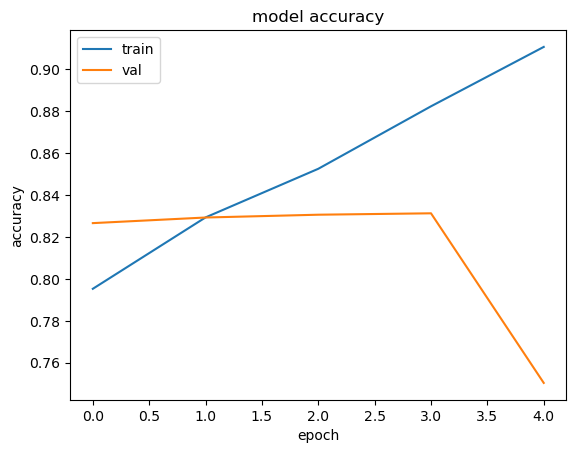

In [33]:
# summarize history for accuracy
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

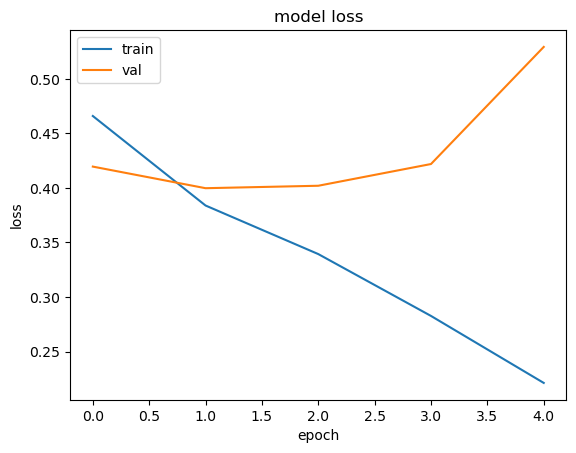

In [34]:
# summarize history for loss
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Try with correct bias initialization

In [35]:
neg, pos = np.bincount(disability_df['toxicity_binary'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 18665
    Positive: 3965 (21.24% of total)



In [36]:
initial_bias = np.log([pos/neg])
initial_bias

array([-1.31034164])

Set that as the initial bias, and the model will give much more reasonable initial guesses.

It should be near: `pos/total = 0.0018`

In [37]:
cnn_model2 = build_cnn_model(num_filters, kernel_sizes, dense_layer_dims, dropout_rate, output_bias=initial_bias)

In [38]:
cnn_history2 = cnn_model2.fit(train_input,
                            train_labels,
                            validation_data=(val_input, val_labels),
                            batch_size=32,
                            epochs=5
                            )

Epoch 1/5
420/420 [==============================] - 9s 21ms/step - loss: 0.4611 - accuracy: 0.8037 - val_loss: 0.4278 - val_accuracy: 0.8099
Epoch 2/5
420/420 [==============================] - 9s 20ms/step - loss: 0.3824 - accuracy: 0.8337 - val_loss: 0.4033 - val_accuracy: 0.8280
Epoch 3/5
420/420 [==============================] - 9s 21ms/step - loss: 0.3313 - accuracy: 0.8584 - val_loss: 0.4086 - val_accuracy: 0.8246
Epoch 4/5
420/420 [==============================] - 8s 20ms/step - loss: 0.2714 - accuracy: 0.8871 - val_loss: 0.4319 - val_accuracy: 0.8199
Epoch 5/5
420/420 [==============================] - 9s 21ms/step - loss: 0.2108 - accuracy: 0.9126 - val_loss: 0.4630 - val_accuracy: 0.8199


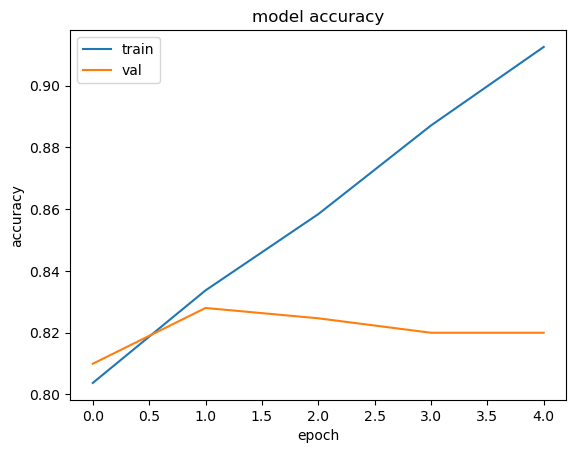

In [39]:
# summarize history for accuracy
plt.plot(cnn_history2.history['accuracy'])
plt.plot(cnn_history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

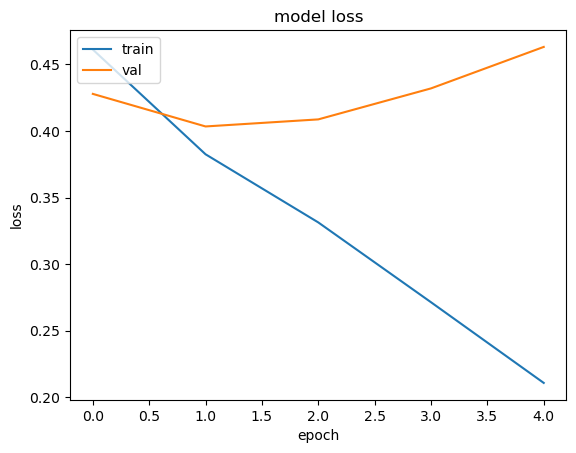

In [40]:
# summarize history for loss
plt.plot(cnn_history2.history['loss'])
plt.plot(cnn_history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Address Data Imbalance with Keras Class Weights

### Calculate class weights
The goal is to identify toxic comments, but we don't have very many of those positive samples to work with, so we would want to have the classifier heavily weight the few examples that are available. We can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.

In [41]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.63
Weight for class 1: 2.35


### Train a model with correct bias initialization and class weights

In [57]:
cnn_model_bias_weighted = build_cnn_model(num_filters, kernel_sizes, dense_layer_dims, dropout_rate, output_bias=initial_bias)
cnn_history_bias_weighted = cnn_model_bias_weighted.fit(train_input,
                            train_labels,
                            validation_data=(val_input, val_labels),
                            batch_size=32,
                            epochs=5,
                            # The class weights go here
                            class_weight=class_weight)

Epoch 1/5
420/420 [==============================] - 10s 21ms/step - loss: 0.6202 - accuracy: 0.6715 - val_loss: 0.5967 - val_accuracy: 0.6934
Epoch 2/5
420/420 [==============================] - 8s 20ms/step - loss: 0.5009 - accuracy: 0.7597 - val_loss: 0.4235 - val_accuracy: 0.8099
Epoch 3/5
420/420 [==============================] - 8s 19ms/step - loss: 0.4243 - accuracy: 0.8058 - val_loss: 0.5355 - val_accuracy: 0.7249
Epoch 4/5
420/420 [==============================] - 8s 20ms/step - loss: 0.3389 - accuracy: 0.8455 - val_loss: 0.4481 - val_accuracy: 0.8092
Epoch 5/5
420/420 [==============================] - 8s 20ms/step - loss: 0.2635 - accuracy: 0.8819 - val_loss: 0.4974 - val_accuracy: 0.8193


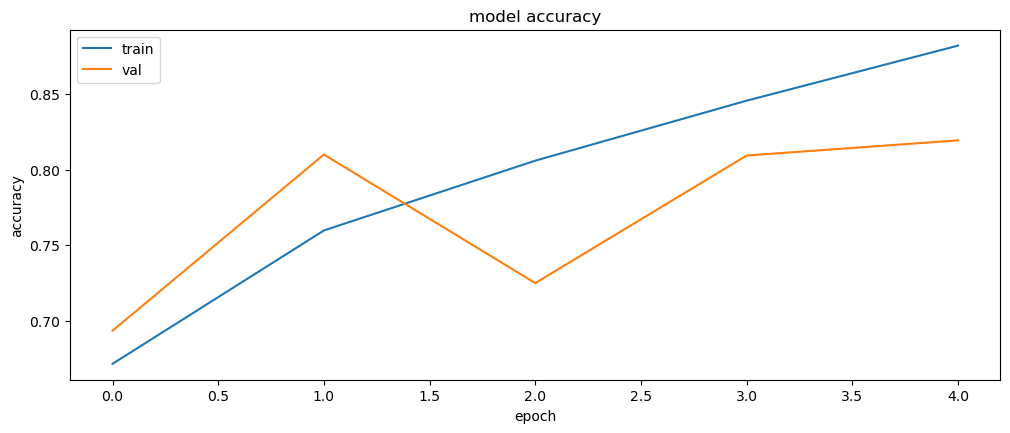

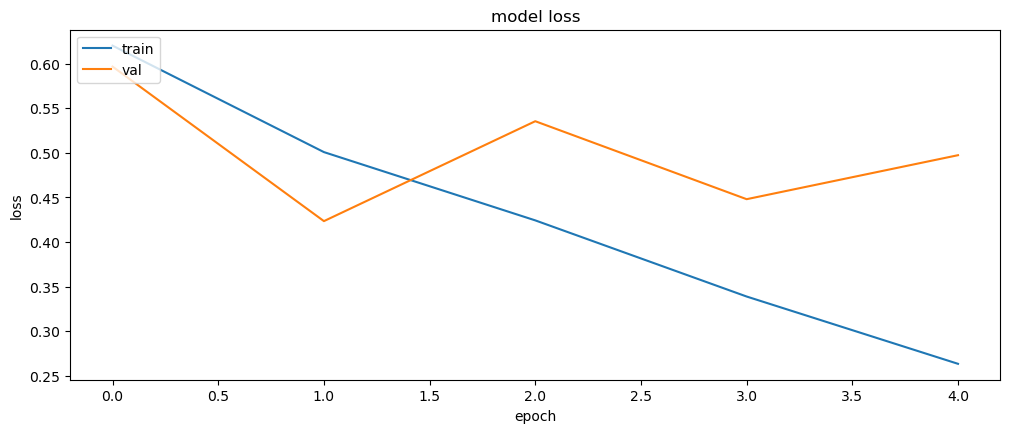

In [58]:
# summarize history for accuracy
plt.subplot(2, 1, 1)
plt.plot(cnn_history_bias_weighted.history['accuracy'])
plt.plot(cnn_history_bias_weighted.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.subplot(2, 1, 2)
plt.plot(cnn_history_bias_weighted.history['loss'])
plt.plot(cnn_history_bias_weighted.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [59]:
cnn_model_bias_weighted2 = build_cnn_model(num_filters, kernel_sizes, dense_layer_dims, dropout_rate, output_bias=initial_bias)
cnn_history_bias_weighted2 = cnn_model_bias_weighted2.fit(train_input,
                            train_labels,
                            validation_data=(val_input, val_labels),
                            batch_size=32,
                            epochs=10,
                            # The class weights go here
                            class_weight=class_weight)

Epoch 1/10
420/420 [==============================] - 9s 19ms/step - loss: 0.6133 - accuracy: 0.6860 - val_loss: 0.4524 - val_accuracy: 0.7999
Epoch 2/10
420/420 [==============================] - 8s 19ms/step - loss: 0.4970 - accuracy: 0.7654 - val_loss: 0.4271 - val_accuracy: 0.7985
Epoch 3/10
420/420 [==============================] - 8s 20ms/step - loss: 0.4215 - accuracy: 0.8040 - val_loss: 0.4656 - val_accuracy: 0.7604
Epoch 4/10
420/420 [==============================] - 8s 20ms/step - loss: 0.3448 - accuracy: 0.8445 - val_loss: 0.4345 - val_accuracy: 0.8012
Epoch 5/10
420/420 [==============================] - 8s 20ms/step - loss: 0.2719 - accuracy: 0.8797 - val_loss: 0.4592 - val_accuracy: 0.8199
Epoch 6/10
420/420 [==============================] - 8s 20ms/step - loss: 0.2065 - accuracy: 0.9104 - val_loss: 0.5312 - val_accuracy: 0.8153
Epoch 7/10
420/420 [==============================] - 8s 19ms/step - loss: 0.1800 - accuracy: 0.9252 - val_loss: 0.5187 - val_accuracy: 0.8166

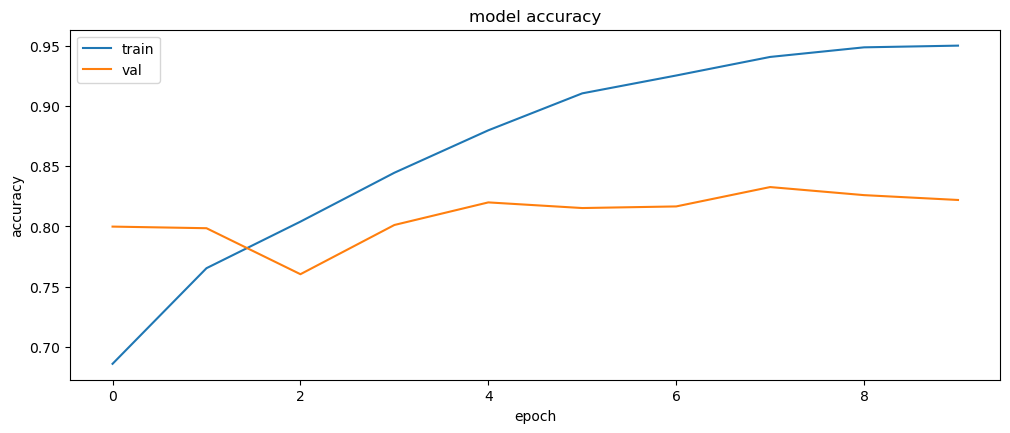

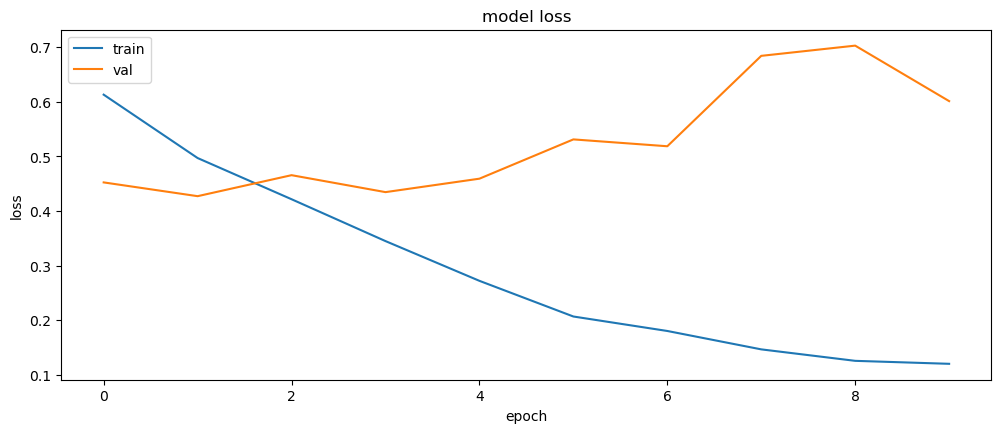

In [60]:
# summarize history for accuracy
plt.subplot(2, 1, 1)
plt.plot(cnn_history_bias_weighted2.history['accuracy'])
plt.plot(cnn_history_bias_weighted2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.subplot(2, 1, 2)
plt.plot(cnn_history_bias_weighted2.history['loss'])
plt.plot(cnn_history_bias_weighted2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

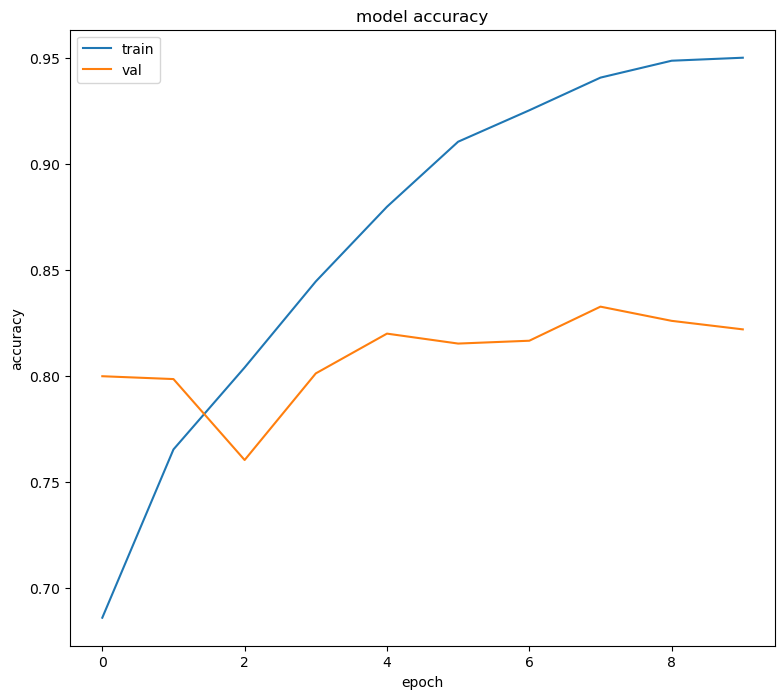

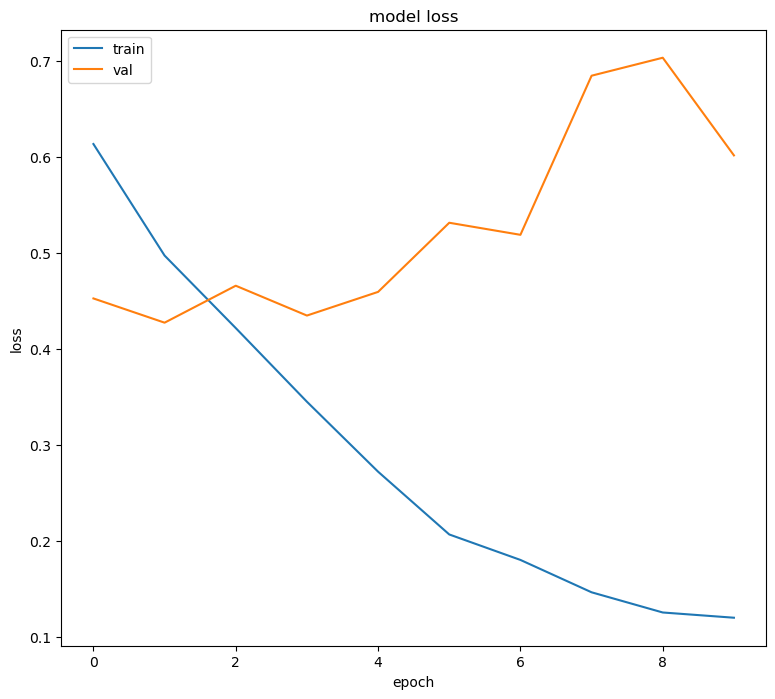

In [67]:
mpl.rcParams['figure.figsize'] = (20, 8)

# summarize history for accuracy
plt.subplot(1, 2, 1)
plt.plot(cnn_history_bias_weighted2.history['accuracy'])
plt.plot(cnn_history_bias_weighted2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(cnn_history_bias_weighted2.history['loss'])
plt.plot(cnn_history_bias_weighted2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()